In [1]:
import os
from dotenv import load_dotenv

load_dotenv()


True

Agent Schema

In [2]:
from typing_extensions import TypedDict
from pydantic import BaseModel, Field
from typing import Annotated, List, Optional, Literal
import operator

# defines structure for each section of the report
class Section(BaseModel):
    name: str = Field(
        description = "Name for a particular section of the report.",
    )
    description: str = Field(
        description = "Brief overview of the main topics and concepts to be covered in this section.",
    )
    research: bool = Field(
        description = "Wheather to perform web search for this section of the report.",
    )
    content: str = Field(
        description = "The content for this section.",
    )

class Sections(BaseModel):
    sections: List[Section] = Field(
        description = "All the Sections for the overall report.",
    )

# defines structure for queries generated for deep research
class SearchQuery(BaseModel):
    search_query: str = Field(None, description = "Query for web search.")

class Queries(BaseModel):
    queries: List[SearchQuery] = Field(
        description = "List of web search queries.",
    )

# consists of input topic and output report generated
class ReportStateInput(TypedDict):
    topic: str # report topic

class ReportStateOutput(TypedDict):
    final_report: str # final report

# overall agent state which will be passed and updated in the nodes of the graph
class ReportState(TypedDict):
    topic: str
    sections: list[Section]
    completed_sections: Annotated[list, operator.add]
    report_sections_from_research: str
    final_report: str

# defines the structure for sections written using the agent
class SectionState(TypedDict):
    section: Section
    search_queries: list[SearchQuery]
    source_str: str
    report_sections_from_research: str
    completed_sections: list[Section]

class SectionOutputState(TypedDict):
    completed_sections: list[Section]



Utility Functions

In [ ]:
from langchain_tavily.tavily_search import TavilySearchAPIWrapper
import asyncio
from dataclasses import asdict, dataclass
from typing import Dict, Any, Union, List
import tiktoken

@dataclass
class SearchQuery:
    search_query: str
    def to_dict(self) -> Dict[str, Any]:
        return asdict(self)
    
tavily_search = TavilySearchAPIWrapper()

async def run_search_queries(
        search_queries: List[Union[str, SearchQuery]],
        num_results: int = 5,
        include_raw_content: bool = False
) -> List[Dict]:
    search_tasks = []

    for query in search_queries:
        # handling both string and SearchQuery objects
        query_str = query.search_query if isinstance(query, SearchQuery) else str(query)

        try:
            search_tasks.append(
                tavily_search.raw_results_async(
                    query = query_str,
                    max_results = num_results,
                    search_depth = 'advanced',
                    include_answer = False,
                    include_raw_content = include_raw_content,
                    include_domains = None,
                    exclude_domains = None,
                    include_images = False,
                    include_image_descriptions = False,
                    include_favicon = False,
                    topic = None,
                    time_range = None,
                    country = None,
                    auto_parameters = False,
                    start_date = None,
                    end_date = None
                )
            )
        except Exception as e:
            print(f"Error creating search task for query '{query_str}' : {e}")
            continue

    try:
        if not search_tasks:
            return []
        search_docs = await asyncio.gather(*search_tasks, return_exceptions = True)
        for doc in search_docs:
            if isinstance(doc, Exception):
                print("EXCEPTION:", doc)
        valid_results = [doc for doc in search_docs if not isinstance(doc, Exception)]

        return valid_results
    except Exception as e:
        print(f"Error during search queries : {e}")
        return []


def format_search_query_results(
        search_response: Union[Dict[str, Any], List[Any]],
        max_tokens: int = 2000,
        include_raw_content: bool = False
) -> str:
    encoding = tiktoken.encoding_for_model("gpt-4")
    sources_list = []
    
    # handling different response formats
    if isinstance(search_response, dict):
        if 'results' in search_response:
            sources_list.extend(search_response['results'])
        else:
            sources_list.append(search_response)
    elif isinstance(search_response, list):
        for response in search_response:
            if isinstance(response, dict):
                if 'results' in response:
                    sources_list.extend(response['results'])
                else:
                    sources_list.append(response)
            elif isinstance(response, list):
                sources_list.extend(response)
    
    if not sources_list:
        return "No search results found."
    
    # duplicate by url and keep unique sources (website urls)
    unique_sources = {}
    for source in sources_list:
        if isinstance(source, dict) and 'url' in source:
            if source['url'] not in unique_sources:
                unique_sources[str(source['url'])] = source

    # format output
    formatted_text = "Content from web search:\n\n"
    for i, source in enumerate(unique_sources.values(), 1):
        formatted_text += f"Source {source.get('title', 'Untitled')}:\n===\n"
        formatted_text += f"URL: {source.get('url')}\n===\n"
        formatted_text += f"Most relevant content from source: {source.get('content', 'No content available')}\n===\n"

        if include_raw_content:
            raw_content = source.get("raw_content", "")
            if raw_content:
                tokens = encoding.encode(raw_content)
                truncated_tokens = tokens[:max_tokens]
                truncated_content = encoding.decode(truncated_tokens)
                formatted_text += f"Raw Content: {truncated_content}\n\n"

    return formatted_text.strip()

In [4]:
docs = await run_search_queries(['langgraph'], include_raw_content = True)
docs

[{'query': 'langgraph',
  'follow_up_questions': None,
  'answer': None,
  'images': [],
  'results': [{'url': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/',
    'title': 'Learn LangGraph basics - Overview',
    'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.',
    'score': 0.9310187,
    'raw_content': '[Skip to main content](#content-area)\n\n* [Overview](/oss/python/langgraph/overview)\n\n##### Get started\n\n* [Install](/oss/python/langgraph/install)\n* [Quickstart](/oss/python/langgraph/quickstart)\n* [Local server](/oss/python/langgraph/local-server)\n* [Thi

In [5]:
docs[0]

{'query': 'langgraph',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://langchain-ai.github.io/langgraph/concepts/why-langgraph/',
   'title': 'Learn LangGraph basics - Overview',
   'content': 'Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.\nLangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.',
   'score': 0.9310187,
   'raw_content': '[Skip to main content](#content-area)\n\n* [Overview](/oss/python/langgraph/overview)\n\n##### Get started\n\n* [Install](/oss/python/langgraph/install)\n* [Quickstart](/oss/python/langgraph/quickstart)\n* [Local server](/oss/python/langgraph/local-server)\n* [Thinking in 

In [6]:
output = format_search_query_results(docs, max_tokens = 500, include_raw_content = True)
print(output)

Content from web search:

Source Learn LangGraph basics - Overview:
===
URL: https://langchain-ai.github.io/langgraph/concepts/why-langgraph/
===
Most relevant content from source: Trusted by companies shaping the future of agents— including Klarna, Replit, Elastic, and more— LangGraph is a low-level orchestration framework and runtime for building, managing, and deploying long-running, stateful agents.
LangGraph is very low-level, and focused entirely on agent orchestration. Before using LangGraph, we recommend you familiarize yourself with some of the components used to build agents, starting with models and tools.
===
Raw Content: [Skip to main content](#content-area)

* [Overview](/oss/python/langgraph/overview)

##### Get started

* [Install](/oss/python/langgraph/install)
* [Quickstart](/oss/python/langgraph/quickstart)
* [Local server](/oss/python/langgraph/local-server)
* [Thinking in LangGraph](/oss/python/langgraph/thinking-in-langgraph)
* [Workflows + agents](/oss/python/lan

Default Report Template
- This is the starting point for the LLM to get an idea of how to build a general report and it will use this to build a custom report structure

In [7]:
DEFAULT_REPORT_STRCUTURE = """The report structure should focus on breaking-down the user-provided topic
                              and building a comprehensive report in markdown using the following format:

                              1. Introduction (no web search needed)
                                    - Brief overview of the topic area

                              2. Main Body Section:
                                    - Each section should focus on a sub-topic of the user-provided topic
                                    - Include any key concepts and definitions
                                    - Provide real-world examples or case studies where applicable

                              3. Conclusion (no web search needed)
                                    - Aim for 1 structural element (either a list of table) that distills the main body sections
                                    - Provide a concise summary of the report

                              When generating the final reponse in markdown, if there are special characters in the text,
                              such as dollar symbol, ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5

                            """

Report plan query generator prompt
- As the llm can't generate sub sections based on a singe line (just topic).
- this prompt helps llm to generate an initial list of questions based on the topic to get more information from the web abou the topic, so that it can plan overall sections and structure of the report

In [8]:
REPORT_PLAN_QUERY_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.
The report will be focused on the following topic:
{topic}

The report structure will follow these guidelines:
{report_organization}

Your goal is to generate {number_of_queries} search queries that will help gather comprehensive information for planning the report sections.

The query sholuld:
1. Be related to the topic
2. Help satisfy the requirements specified in the report organization

Make the query specific enough to find high-quality, relevant sources while covering the depth and breadth needed for the report structure.
"""

Report plan section generator prompt
- We feed the llm with the default report template, the topic name and the search results from the initial queries generated to create a detailed structure for the report.
- The llm will generate a structured response of the following fields for each major section which will be in the report:
    - Name: name for this section of the report
    - Description: brief overview of the main topics and concepts to be covered in this section.
    - Research: whether to perform web search for this section of the report or not.
    - Content: content of the section, which you will leave blank for now.

In [9]:
REPORT_PLAN_SECTION_GENERATOR_PROMPT = """You are an expert technical report writer, helping to plan a report.

Your goal is to generate the outline of the sections of the report.

The overall topic of the report is:
{topic}

The report should follow this organizational structure:
{report_organization}

You should reflect on this additional context information from web searches to plan the main sections of the report:
{search_context}

Now, generate the sections of the report, Each section should have the following fields:
- Name - Name for this section of the report.
- Description - Brief overview of the main topics and concepts to be covered in this section.
- Research - Whether to perform web search for this section of the report or not.
- Content - The content of the section, which you will leave blank for now.

Consider which sections require web search.
For example, introduction and conclusion will not require research because they will distill information from other parts of the report.
"""

Node Function for Report Planner
- the objective is to create a structured custom report template with major section names and descriptions based on the input user topic and the default report template guidlines.
- this function uses the 2 prompts created earlier to:
    - generate some quires based on the user topic
    - search web and get some information on these queries
    - use this information to generate the overall structure of the report with the key sections necessary to be created

In [ ]:
from langchain_openai import ChatOpenAI
from langchain_core.messages import HumanMessage, SystemMessage

# llm = ChatOpenAI(model_name = "gpt-4o", temperature = 0)
llm = ChatOpenAI(
    model="gpt-4o-mini",   # Lighter model — lower token cost, same API format
    temperature=0.4,       
    max_tokens=1024,        # Reduced output length to save TPM
    request_timeout=30,    # Prevents hanging requests
)

async def generate_report_plan(state : ReportState):
    """Generate the overall plan for building the report"""
    topic = state["topic"]
    print("--- Generating Report Plan ---")

    report_structure = DEFAULT_REPORT_STRCUTURE
    number_of_queries = 6

    structured_llm = llm.with_structured_output(Queries)

    system_instructions_query = REPORT_PLAN_QUERY_GENERATOR_PROMPT.format(
        topic = topic,
        report_organization = report_structure,
        number_of_queries = number_of_queries
    )

    try:
        # generate queries
        results = structured_llm.invoke([
            SystemMessage(content = system_instructions_query),
            HumanMessage(content = "Generate search queries that will help with planning the sections of the report.")
        ])
        # convert SearchQuery objects to strings
        query_list = [
            query.search_query if isinstance(query, SearchQuery) else str(query)
            for query in results.queries
        ]
        # search web and ensure we wait for results
        search_docs = await run_search_queries(
            query_list,
            num_results = 5,
            include_raw_content = False
        )
        if not search_docs:
            print("Warning : No search results returned")
            search_context = "No search results available."
        else:
            search_context = format_search_query_results(
                search_docs,
                include_raw_content = False
            )
        # generate sections
        system_instructions_sections = REPORT_PLAN_SECTION_GENERATOR_PROMPT.format(
            topic = topic,
            report_organization = report_structure,
            search_context = search_context
        )
        structured_llm = llm.with_structured_output(Sections)
        report_sections = structured_llm.invoke([
            SystemMessage(content = system_instructions_sections),
            HumanMessage(content = "Generate the sections of the report. Your response must include a 'sections' field containing a list of sections. Each section must have: name, description, plan, research, and content fields.")
        ])

        print("--- Generating Report Plan Completed ---")
        return {"sections" : report_sections.sections}
    
    except Exception as e:
        print(f"Error in generate_report_plan : {e}")
        return {"Sections" : []}

Report section query generator prompt
- helps llm to generate a comprehensive list of questions for the topic of that section which needs to be built

In [11]:
REPORT_SECTION_QUERY_GENERATOR_PROMPT = """Your goal is to generate targeted web search queries that will gather comprehensive information for writing a technical report section.

Topic for this section:
{section_topic}

When generating {number_of_queries} search queries, ensure that they:
1. Cover different aspects of the topic (e.g., core features, real-world applications, technical architecture)
2. Include specific technical terms related to the topic.
3. Target recent information by including year markers where relevant (e.g., "2024)
4. Look for comparisons or differentiators from similar technologies/approaches
5. Search for both official documentation and practical implementation examples

Your queries should be:
- Specific enough to avoid generic results
- Technical enough to capture detailed implementation information
- Diverse enough to cover all aspects of the section plan
- Focused on authoritative sources (documentation, technical blogs, academic papers)
"""

Node function for section builder 
- generate queries (query generator)
- this uses section topic and instuction prompt written above to generate some questions for researching on the web to get useful information on the section topic.

In [12]:
def generate_queries(state : SectionState):
    """ Generate search queries for a specific report section """
    
    # get state
    section = state["section"]
    print("--- Generating Search Queries for Section : " + section.name + " ---")
    number_of_queries = 8
    structured_llm = llm.with_structured_output(Queries)
    system_instructions = REPORT_SECTION_QUERY_GENERATOR_PROMPT.format(
        section_topic = section.description,
        number_of_queries = number_of_queries
    )
    # generate queries
    user_instruction = "Generate search queries on the provided topic."
    search_queries = structured_llm.invoke([SystemMessage(content = system_instructions),
                                            HumanMessage(content = user_instruction)])
    print("--- Generating Search Queries for Section : " + section.name + " Completed ---")
    return {"search_queries" : search_queries.queries}

Node function for Section Builder - Search Web
- takes the queries generated by generate_queries() function for a specific section, searches the web and formats the search results using the utility functions

In [13]:
async def search_web(state : SectionState):
    """ Search the web for each query, then return a list of raw sources and a formatted string of sources """

    # get state
    search_queries = state["search_queries"]
    print("--- Searching Web for Queries ---")
    # web search
    query_list = [query.search_query for query in search_queries]
    search_docs = await run_search_queries(search_queries, num_results = 2, include_raw_content = True)
    # deduplicate and format sources
    search_context = format_search_query_results(search_docs, max_tokens = 2000, include_raw_content = True)

    print("--- Searching Web for Queries Completed ---")
    return {"source_str" : search_context}

Section writer prompt
- prompt to the llm to generate and write the content for a specific section with certain guidelines on style, strcuture, length, approach and the documents from the web earlier using the search_web() are also sent.

In [ ]:
SECTION_WRITER_PROMPT = """You are an expert technical writer crafting one specific section of a technical report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Guidelines for writing:

1. Technical Accuracy:
- Inlcude specific version numbers
- Reference concrete metrics/benchmarks
- Cite official documentation
- Use technical terminology precisely

2. Length and Style:
- Strict 150-200 word limit
- No marketing language
- Technical focus
- Write in simple, clear language do not use complex words unnecessarily
- Start with your most important insight in **bold**
- Use short paragraphs (2-3 sentences max)

3. Structure:
- Use ## for section title (Markdown format)
- Only use ONE structural element IF it helps clarify your point:
    * Either a focused table comparing 2-3 key items (using Markdown table syntax)
    * Or a short list (3-5 items) using proper Markdown list syntax:
        - Use `*` or `-` for unordered lists
        - Use `1.` for ordered lists
        - Ensure proper indentation and spacing
- End with ### Sources that references the below source material formatted as:
    * List each source with title, date, and URL
    * Format:`- Title : URL`

4. Writing Approach:
- Include at least one specific example or case study if available
- Use concrete details over general statements
- Make every word count
- No preamble prior to creating the section content
- Focus on your single most important point

5. Use this source material obtained from web searches to help write the section:
{context}

6. Quality Checks:
- Format should be Markdown
- Exactly 150-200 words (excluding title and sources)
- Careful use of only ONE structural element (table or bullet list) and only if it helps clarify your point
- One specific example / case study if available
- Starts with bold insight
- No preamble prior to creating the section content
- Sources cited at end
- If there are special characters in the text, such as the dollar symbol,
  ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

Node function for Section Builder - Write Section(Section Writer)
- uses SECTION_WRITER_PROMPT and feeds it with the section name, description and web search documents and passes it to llm to write the content for that section

In [15]:
def write_section(state : SectionState):
    """ Write a section of the report """
    # get state
    section = state["section"]
    source_str = state["source_str"]
    print("--- Writing Section : " + section.name + " ---")
    system_instructions =   SECTION_WRITER_PROMPT.format(
        section_title = section.name,
        section_topic = section.description,
        context = source_str
    )
    user_instruction = "Generate a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content = system_instructions),
                                  HumanMessage(content = user_instruction)])
    # write content to the section object
    section.content = section_content.content
    print("--- Writing Section : " + section.name + " Completed ---")
    return {"completed_sections" : [section]}

Section builder sub-agent
- this agent will be called several times in parallel, once for each section to search the web, get content and then write up that specific section.

C:\Users\Sunny\AppData\Local\Temp\ipykernel_24472\3144464695.py:4: LangGraphDeprecatedSinceV05: `output` is deprecated and will be removed. Please use `output_schema` instead. Deprecated in LangGraph V0.5 to be removed in V2.0.
  section_builder = StateGraph(SectionState, output = SectionOutputState)


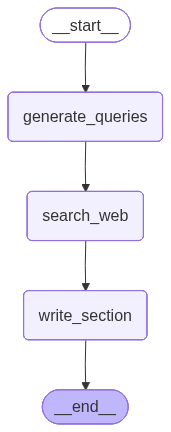

In [16]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
# add nodes
section_builder = StateGraph(SectionState, output = SectionOutputState)
section_builder.add_node("generate_queries", generate_queries)
section_builder.add_node("search_web", search_web)
section_builder.add_node("write_section", write_section)
# add edges
section_builder.add_edge(START, "generate_queries")
section_builder.add_edge("generate_queries", "search_web")
section_builder.add_edge("search_web", "write_section")
section_builder.add_edge("write_section", END)

section_builder_subagent = section_builder.compile()

#display the graph
Image(section_builder_subagent.get_graph().draw_mermaid_png())

Dynamic parallelization node function - Parallelize section writing
- there can be variable number of sections depending on the topic we have, we have a sub-agent to write one section
- we use send() to replicate the sub-agent multiple times once for each section
- send() is used to parallelize and call the section_builder_subagent once for each section to write up the content (in parallel)

In [17]:
from langgraph.constants import Send

def parallelize_section_writing(state : ReportState):
    """ This is the "map" step when we kick off web research for some sections of the report in parallel and then write the section """

    # kick off section writing in parallel via Send() API for any sections that require research
    return [
        Send("section_builder_with_web_search", # name of the subagent node
             {"section" : s})
             for s in state["sections"]
                if s.research
    ]

C:\Users\Sunny\AppData\Local\Temp\ipykernel_24472\81305012.py:1: LangGraphDeprecatedSinceV10: Importing Send from langgraph.constants is deprecated. Please use 'from langgraph.types import Send' instead. Deprecated in LangGraph V1.0 to be removed in V2.0.
  from langgraph.constants import Send


Format sections node function
- this is basically where all the sections are formatted and combined together into one big document

In [18]:
def format_sections(sections : list[Section]) -> str:
    """ Format a list of report sections into a single text string """
    formatted_str = ""
    for idx, section in enumerate(sections, 1):
        formatted_str += f"""
            {'='*60}
            Section {idx} : {section.name}
            {'='*60}
            Description:
            {section.description}
            Requires Research:
            {section.research}

            Content:
            {section.content if section.content else '[Not yet written]'}
        """
    return formatted_str

def format_completed_sections(state : ReportState):
    """ Gather completed sections from research and format them as context for writing the final sections """
    print("--- Formatting Completed Sectoins ---")
    completed_sections = state["completed_sections"]
    completed_report_sections = format_sections(completed_sections)
    print("--- Formatting Completed Sections is Done")
    return {"report_sections_from_research" : completed_report_sections}

Final section writer prompt
- tells the llm to generate and write the content for either the introduction or conclusion using certain guidelines on style, structure, length, approach and the content of the already written sections are also sent

In [19]:
FINAL_SECTION_WRITER_PROMPT = """You are an expert technical writer crafting a section that synthesizes information from the rest of the report.

Title for the section:
{section_title}

Topic for this section:
{section_topic}

Available report content of already completed sections:
{context}

1. Section-Specific Approach:

For Introduction:
- Use # for report title (Markdown format)
- 50-100 word limit
- Write in simple and clear language
- Focus on the core motivation for the report in 1-2 paragraphs
- Use a clear narrative arc to introduce the report
- Include NO structural elements (no lists or tables)
- No sources section needed

For Conclusion/Summary:
- use ## for section title (Markdown format)
- 100-150 word limit
- For comparative reports:
    * Must include a focused comparison table using Markdown table syntax
    * Table should distill insights from the report
    * Keep table entries clear and concise
- For non-comparative reports:
    * Only use ONE structural element IF it helps distill the points made in the report
    * Either a focused table comparing items present in the report (using Markdown table syntax)
    * Or a short list using proper Markdown list syntax:
        - Use `*` or `-` for unordered lists
        - Use `1.` for ordered lists
        - Ensure proper indentation and spacing
- End with specific next steps or implications
- No sources section needed

3. Writing Approach:
- Use concrete details over general statements
- Make every word count
- Focus on your single most important point

4. Quality Checks:
- For introduction: 50-100 word limit, # for report title, no structural elements, no sources section
- For conclusion: 100-150 word limit, ## for section title, only ONE structural at most, no sources section
- Markdown format
- Do not include word count or any preamble in your response
- If there are special characters in the text, such as the dollar symbol,
ensure they are escaped properly for correct rendering e.g $25.5 should become \$25.5
"""

Write final sections node function
- this takes the final_section_writer_prompt to write up the introduction and conclusion
- this function will be executed in parallel using Send() 

In [20]:
def write_final_sections(state : SectionState):
    """ Write the final setions of the report, which do not require web search and use the completed sections as context """

    # get state
    section = state["section"]
    completed_report_sections = state["report_sections_from_research"]
    print("--- Writing Final Section : " + section.name + " ---")
    # format system instructions
    system_instructions = FINAL_SECTION_WRITER_PROMPT.format(
        section_title = section.name,
        section_topic = section.description,
        context = completed_report_sections
    )
    # generate section
    user_instruction = "Craft a report section based on the provided sources."
    section_content = llm.invoke([SystemMessage(content = system_instructions),
                                  HumanMessage(content = user_instruction)])
    # write content to section
    section.content = section_content.content
    print("--- Writing Final Section : " + section.name + "Completed ---")
    return {"completed_sections" : [section]}

Dynamic parallelization node function - parallelize final section writing
- send() is used to parallelize and call the write_final_sections() once for each of the introduction and conclusion to write up the content (in parallel)

In [21]:
def parallelize_final_section_writing(state : ReportState):
    """ Write any final sections using the Send API to parallelize the process """

    # kick off section writing in parallel via Send() API for any sections that do not require research
    return [
        Send("write_final_sections",
             {"section" : s, "report_sections_from_research" : state["report_sections_from_research"]})
                for s in state["sections"]
                    if not s.research
    ]

Compile final report node function
- this combines all the sections of the report together and compiles it into the final report document

In [22]:
def compile_final_report(state : ReportState):
    """ Compile the final report """

    # get sections
    sections = state["sections"]
    completed_sections = {s.name: s.content for s in state["completed_sections"]}
    print("--- Compiling Final Report ---")
    # update sections with completed content while maintaining original order
    for section in sections:
        section.content = completed_sections[section.name]
    
    # compile final report
    all_sections = "\n\n".join([s.content for s in sections])
    # escape unescaped symbols (like $) to display properly in Markdown
    formatted_sections = all_sections.replace("\\$", "TEMP_PLACEHOLDER") # temporarily mark already escaped $
    formatted_sections = formatted_sections.replace("$", "\\$") # escape all $
    formatted_sections = formatted_sections.replace("TEMP_PLACEHOLDER", "\\$") # restore originally escaped

    print("--- Compiling Final Report Done ---")
    return {"final_report" : formatted_sections}

Build our report writer planning agent
- now bring all the defined components and sub-agents together and build main planning agent

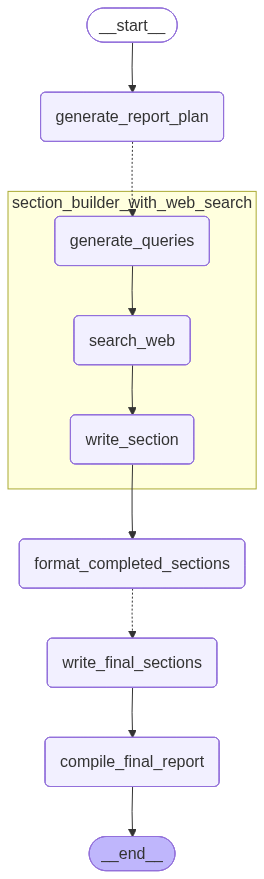

In [23]:
builder = StateGraph(ReportState, input_schema = ReportStateInput, output_schema = ReportStateOutput)

# add nodes
builder.add_node("generate_report_plan", generate_report_plan)
builder.add_node("section_builder_with_web_search", section_builder_subagent)
builder.add_node("format_completed_sections", format_completed_sections)
builder.add_node("write_final_sections", write_final_sections)
builder.add_node("compile_final_report", compile_final_report)

# add edges
builder.add_edge(START, "generate_report_plan")
builder.add_conditional_edges("generate_report_plan",
                              parallelize_section_writing,
                              ["section_builder_with_web_search"])
builder.add_edge("section_builder_with_web_search", "format_completed_sections")
builder.add_conditional_edges("format_completed_sections",
                              parallelize_final_section_writing,
                              ["write_final_sections"])
builder.add_edge("write_final_sections", "compile_final_report")
builder.add_edge("compile_final_report", END)

reporter_agent = builder.compile()

display(Image(reporter_agent.get_graph(xray = True).draw_mermaid_png()))

Test

In [24]:
from rich.console import Console
from rich.markdown import Markdown as RichMarkdown

async def call_planner_agent(agent, prompt, config = {"recursion_limit" : 50}, verbose = False):
    events = agent.astream(
        {'topic' : prompt},
        config,
        stream_mode = "values",
    )

    async for event in events:
        for k, v in event.items():
            if verbose:
                if k != "__end__":
                    display(RichMarkdown(repr(k) + ' -> ' + repr(v)))
            if k == 'final_report':
                print('='*50)
                print("Final Report:")
                md = RichMarkdown(v)
                display(md)

In [27]:
topic = "Detailed report on how to build Agentic AI systems, design patterns and current frameworks"
await call_planner_agent(agent = reporter_agent, prompt = topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section : Understanding Agentic AI ---
--- Generating Search Queries for Section : Key Components of Agentic AI Systems ---
--- Generating Search Queries for Section : Agentic AI Design Patterns ---
--- Generating Search Queries for Section : Current Frameworks for Agentic AI ---
--- Generating Search Queries for Section : Real-World Applications and Case Studies ---
--- Generating Search Queries for Section : Ethical Considerations in Agentic AI ---
--- Generating Search Queries for Section : Challenges in Implementing Agentic AI ---
--- Generating Search Queries for Section : Agentic AI Design Patterns Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Key Components of Agentic AI Systems Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Real-World Applications and Case Studies Completed ---
--- Se

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

Agentic AI systems mark a transformative advancement in artificial intelligence, distinguished by their ability to 
operate autonomously and make decisions in real-time. Unlike traditional AI, which relies heavily on human input   
and predefined rules, agentic AI can adapt to changing environments and pursue specific goals independently. This  
report aims to explore the core characteristics, key components, design patterns, current frameworks, real-world   
applications, ethical considerations, and challenges associated with agentic AI. By understanding these elements,  
we can better appreciate the significance of agentic AI in reshaping industries and driving innovation in          
technology.                                                                                                        


                                             Understanding Agentic AI                                              

Agentic AI represents a significant evolution in artificial intelligence, characterized by its autonomy and        
decision-making capabilities. Unlike traditional AI, which relies on predefined rules and human oversight, agentic 
AI systems can operate independently, set goals, and adapt to dynamic environments. They utilize advanced          
technologies, including large language models (LLMs) and reinforcement learning, to perceive, reason, act, and     
learn in real-time.                                                                                                

Key characteristics of agentic AI include:                                                                         

 • Autonomy: Capable of performing tasks without human intervention.                                               
 • Adaptability: Learns from interactions and adjusts decisions based on feedback.                                 
 • Goal Orientation: Pursues specific objectives through multi-step reasoning.                                     

For example, IBM's agentic AI is utilized in healthcare to develop personalized treatment plans by analyzing       
extensive medical data, improving patient outcomes significantly. In contrast, traditional AI systems typically    
excel in stable environments but struggle with complex, multi-step tasks.                                          

                                                                                             
  Feature           Traditional AI                      Agentic AI                           
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Autonomy          Limited, requires human input       High, operates independently         
  Adaptability      Static, relies on historical data   Dynamic, learns in real-time         
  Decision-Making   Single-step, rule-based             Multi-step, context-aware reasoning  
                                                                                             

                                                      Sources                                                      

 • What Is Agentic AI? - NVIDIA Blog: https://blogs.nvidia.com/blog/what-is-agentic-ai/                            
 • Agentic AI vs. Traditional AI: What Companies Need to Know - Ekotek:                                            
   https://ekotek.vn/agentic-vs-traditional-ai-differences                                                         
 • Agentic AI: The Future of Autonomous Decision-Making [Explained]:                                               
   https://www.landbase.com/blog/agentic-ai-the-future-of-autonomous-decision-making

In [26]:
topic = "Detailed report on how is NVIDIA winning the game against its competitors"
await call_planner_agent(agent = reporter_agent, prompt = topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section : Market Share and Competitive Positioning ---
--- Generating Search Queries for Section : Technological Innovations ---
--- Generating Search Queries for Section : Strategic Partnerships and Collaborations ---
--- Generating Search Queries for Section : Financial Performance and Growth Metrics ---
--- Generating Search Queries for Section : Challenges and Future Outlook ---
--- Generating Search Queries for Section : Technological Innovations Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Challenges and Future Outlook Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Financial Performance and Growth Metrics Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Strategic Partnerships and Collaborations Completed ---
--- Searching Web for Queries ---
-

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

NVIDIA has established itself as a formidable leader in the GPU market, commanding a remarkable 90% market share as
of late 2024. This dominance is fueled by a combination of strong demand for AI applications, innovative           
technological advancements, and strategic partnerships with major tech companies. While competitors like AMD and   
Intel struggle to keep pace, NVIDIA's cutting-edge products and robust ecosystem continue to attract developers and
enterprises alike. This report explores NVIDIA's competitive advantages, market positioning, and the factors       
contributing to its ongoing success in an increasingly competitive landscape.                                      


                                     Market Share and Competitive Positioning                                      

NVIDIA currently holds a dominant 90% share of the GPU market, significantly outpacing competitors AMD and Intel.  
According to Jon Peddie Research, NVIDIA's market share increased from 88% to 90% in Q4 2024, while AMD's share    
dropped from 17% to 10% during the same period. Intel's discrete GPU market presence remains negligible, reported  
at 0% (TechPowerUp, 2025).                                                                                         

The success of NVIDIA can be attributed to several factors:                                                        

 • Strong AI Demand: NVIDIA's GPUs are preferred for AI applications, with the data center GPU market projected to 
   reach $125 billion, where NVIDIA holds a 92% market share (IoT Analytics, 2025).                                
 • CUDA Ecosystem: The CUDA platform enables extensive software support, fostering a large developer community that
   enhances NVIDIA's product appeal (EE Times Europe, 2024).                                                       
 • Product Lineup: The recent launch of the RTX 50 series has further solidified NVIDIA's lead, while AMD's RDNA 4 
   GPUs have faced delays (TechPowerUp, 2025).                                                                     

In contrast, AMD and Intel are struggling to gain traction, with AMD's shipments declining and Intel's market entry
yielding minimal results (The Register, 2024).                                                                     

                                                      Sources                                                      

 • Nvidia achieves the highest GPU market share of its history - OC3D:                                             
   https://overclock3d.net/news/gpu-displays/nvidia-destroys-the-competition-and-achieves-the-highest-gpu-market-sh
   are-of-its-history/                                                                                             
 • NVIDIA Grabs Market Share, AMD Loses Ground, and Intel Disappears in Latest dGPU Update - TechPowerUp:          
   https://www.techpowerup.com/337775/nvidia-grabs-market-share-amd-loses-ground-and-intel-disappears-in-latest-dgp
   u-update                                                                                                        
 • The leading generative AI companies - IoT Analytics: https://iot-analytics.com/leading-generative-ai-companies/ 
 • Nvidia GTC 2024: Why Nvidia Dominates AI - EE Times Europe:                                                     
   https://www.eetimes.eu/nvidia-gtc-2024-why-nvidia-dominates-ai/                                                 
 • Intel entrance to graphics card market has failed - The Register:                                               
   https://www.theregister.com/2024/10/02/intel

In [29]:
topic = "Comprehensive Analysis of the Impact of Artificial Intelligence on the Technology Job Market: Trends, Challenges, and Future Prospects in 2025"
await call_planner_agent(agent = reporter_agent, prompt = topic)

--- Generating Report Plan ---
--- Generating Report Plan Completed ---
--- Generating Search Queries for Section : Current Trends in AI Job Market ---
--- Generating Search Queries for Section : Job Displacement and Creation ---
--- Generating Search Queries for Section : Skills and Qualifications for AI Roles ---
--- Generating Search Queries for Section : Challenges in the AI Job Market ---
--- Generating Search Queries for Section : Future Prospects of AI in the Job Market ---
--- Generating Search Queries for Section : Challenges in the AI Job Market Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Current Trends in AI Job Market Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Skills and Qualifications for AI Roles Completed ---
--- Searching Web for Queries ---
--- Generating Search Queries for Section : Future Prospects of AI in the Job Market Completed ---
--- Searching Web for Queries ---
--

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃                                                  Introduction                                                   ┃
┗━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┛

The impact of artificial intelligence (AI) on the technology job market is profound and multifaceted. As AI        
technologies become increasingly integrated into various sectors, they are reshaping job roles, creating new       
opportunities, and posing challenges related to job displacement. This report explores the current trends in AI job
growth, the balance of job creation and displacement, the essential skills required for AI roles, the challenges   
faced by the workforce, and future prospects for employment in an AI-driven landscape. Understanding these dynamics
is crucial for stakeholders aiming to navigate the evolving job market effectively.                                


                                          Current Trends in AI Job Market                                          

The AI job market is experiencing unprecedented growth, with job postings for AI-related roles surging by 61%      
year-on-year in 2024. This trend is driven by the widespread integration of AI technologies across various sectors,
including healthcare, finance, and retail. For instance, the healthcare sector is leading AI adoption, enhancing   
diagnostics and operational efficiency, which has resulted in a significant increase in demand for AI specialists. 

Salary expectations for AI roles are also rising. Machine Learning Engineers command an average salary of $158,420,
while Data Scientists earn around $124,180. Notably, roles such as Robotics Software Engineer have seen a          
staggering salary increase of 51.7% from 2023 to 2025, reflecting the growing importance of AI skills in the job   
market.                                                                                                            

The sectors experiencing the most growth in AI jobs include Information Technology, Professional Services, and     
Healthcare, with companies like Google and Amazon leading in hiring. This indicates a shift towards embedding AI   
capabilities across all business functions, not just within IT departments.                                        

                                                      Sources                                                      

 • The Fearless Future: 2025 Global AI Jobs Barometer - PwC:                                                       
   https://www.pwc.com/gx/en/issues/artificial-intelligence/ai-jobs-barometer.html                                 
 • The Generative AI Job Market: 2025 Data Insights - Lightcast:                                                   
   https://lightcast.io/resources/blog/the-generative-ai-job-market-2025-data-insights                             
 • Report reveals top-paying emerging AI jobs in 2025 | Onrec:                                                     
   https://www.onrec.com/news/news-archive/report-reveals-top-paying-emerging-ai-jobs-in-2025                      
 • AI Talent Demand 2024–2025: Skills & Global Hiring Trends - LinkedIn:                                           
   https://www.linkedin.com/pulse/demand-ai-talent-2024-2025-global-tech-job-market-analysis-rathi-s82jc           


                                           Job Displacement and Creation                                           

AI is expected to create 97 million new jobs while displacing 85 million by 2025. This dual impact highlights the  
transformative role of AI in the labor market. According to the World Economic Forum, roles in AI and technology   
are among the fastest-growing job categories, with a projected increase of 69 million new jobs globally by 2028.   

Conversely, jobs most at risk of automation 